# CTSM fire refactor to allow FATES to use GDP data

This notebook attempts to determine if the raw GDP data available through ctsm is correctly being passed to FATES.  The code currently uses a [simple modified branch of FATES](https://github.com/glemieux/fates/tree/fire-gdp-simpletest) that assigns the `bc_in%gdp` variable to a standard site-level history output variable `FIRE_GDP`.  

## Setup notebook

In [1]:
import numpy as np
import xarray as xa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Import data

In [2]:
gdp_lobata_noncol = xa.open_dataset('gdp-test-brazil.fates.lobata.C545b29d3-F17a71c48.clm2.h0.2000.nc')
gdp_lobata_col = xa.open_dataset('gdp_lf_col-test-brazil.fates.lobata.Cbaa65024-F17a71c48.clm2.h0.2000.nc')

## Plot data comparisons

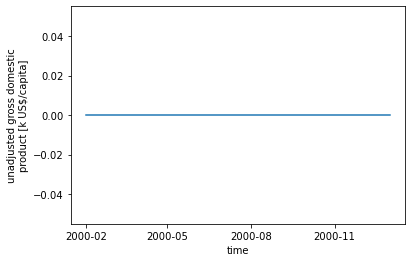

In [3]:
gdp_lobata_noncol.FIRE_GDP.plot()

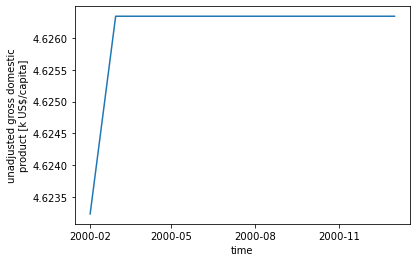

In [4]:
gdp_lobata_col.FIRE_GDP.plot()